In [3]:
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from dtaidistance import dtw
from dtaidistance import ed
import json

In [83]:
df = pd.read_csv(
    './datasets/complaint_census_join.csv',  
    names=[
        'zcta', 'complaint datetime', 'complaint type', 
        'complaint descriptor', 'hour', 'weekday', 'year', 'geoID', 'median earning', 
        'full time median earning', 'full time mean'])

## adding a helper counter
df['counter'] = 1

## cleaning
df = df[df['median earning'] != '-']

## casting meadian earning columns
df = df.astype({'median earning': 'int'}, errors='ignore')

/Users/jlrulff/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Phased reopening Analysis

In [84]:
current_df = df[df['year'] == 2020]
current_df = current_df[current_df['complaint type'] == 'NonCompliance with Phased Reopening']
current_df.sort_values(by='complaint datetime', inplace=True)
current_df['day'] = pd.to_datetime(current_df['complaint datetime'])
current_df['day'] = current_df['day'].dt.strftime('%m/%d/%Y')

groupby_phased = current_df[['day', 'counter']].groupby(by='day').sum()

plt.plot(groupby_phased.reset_index()['day'],groupby_phased.reset_index()['counter'])
plt.title('title name')
plt.xlabel('xAxis name')
plt.ylabel('yAxis name')
plt.show()

## Plots

Wealthiest...


/Users/jlrulff/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


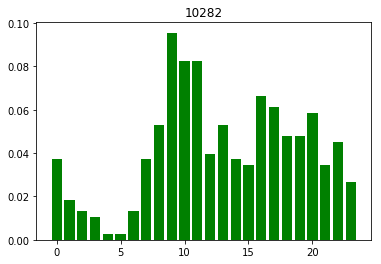

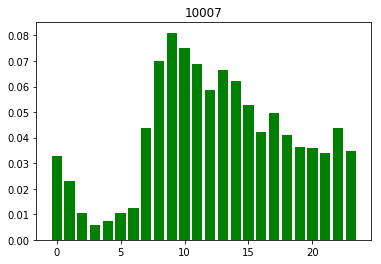

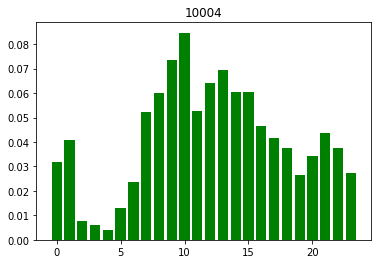

Poorest...


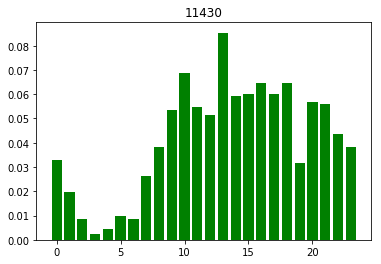

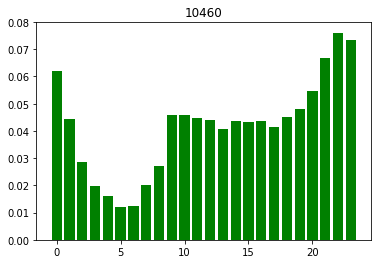

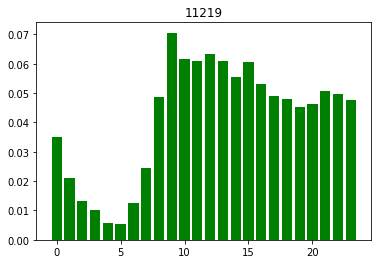

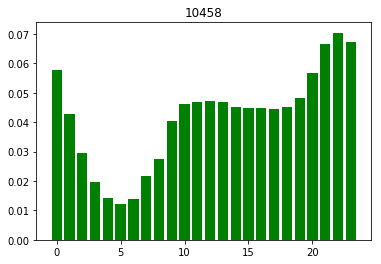

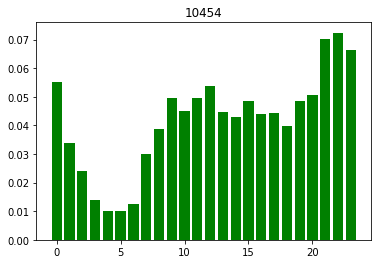

TOP-5 Wealthiest Phased Reopening Complaints 230
TOP-5 Poorest Phased Reopening Complaints 905


In [61]:
# years = [2020, 2019, 2018, 2017]
years = [2020]
pairwise_spatial_dtw = {}

for year in years:
    
    
    ## filtering DF
    current_df = df[df['year'] == year]
#     current_df = current_df[current_df['complaint type'].str.contains("Noise")]

    ## grouping DF by ZCTA and hour
    groupby = current_df[['zcta', 'hour', 'counter', 'median earning']].groupby(by=['zcta', 'hour']).agg({'counter': 'sum', 'median earning': 'first'})

    ## all zctas
    zctas = list(groupby.index.get_level_values(0).unique())

#     ## getting feature vectors for projections
#     feature_vectors, earnings, zctas = get_feature_vectors(zctas, groupby)
    
#     ## calculating spatial dtw
#     current_year_spatial_dtw = pairwise_spatial_zcta(zctas, feature_vectors)
#     pairwise_spatial_dtw[str(year)] = current_year_spatial_dtw
    
#     print('Year: ', year)
#     plot_PCA(feature_vectors, earnings, year)
#     plot_TSNE(feature_vectors, earnings, year)

    ## calculating average DTW between vectors
#     pairwise_dtw =average_DTW(feature_vectors)
#     print('Average pairwise distance: ', pairwise_dtw)
    
    
    ## bar plots
    print('Wealthiest...')
    top_k = get_top_k(current_df, False, 5)
    feature_vectors, earnings, zctas = get_feature_vectors(top_k, groupby)   
    hours = [i for i in range(24)]
    plot_bar_plot(feature_vectors, hours, zctas, year, 'Wealthiest')
    
    print('Poorest...')
    last_k = get_top_k(current_df, True, 5)
    feature_vectors, earnings, zctas = get_feature_vectors(last_k, groupby)   
    hours = [i for i in range(24)]
    plot_bar_plot(feature_vectors, hours, zctas, year, 'Poorest')  


    ## covid specific attributes
    current_df = df[df['year'] == year]
    current_df = current_df[current_df['complaint type'] == 'NonCompliance with Phased Reopening']
    groupby = current_df[['zcta', 'counter', 'median earning']].groupby(by=['zcta']).agg({'counter': 'sum', 'median earning': 'first'})
    
    print('TOP-5 Wealthiest Phased Reopening Complaints', np.sum(groupby.loc[top_k]['counter'].values))
    print('TOP-5 Poorest Phased Reopening Complaints', np.sum(groupby.loc[last_k]['counter'].values))

# save_json('./pairwise_spatial_ed_noise.json', pairwise_spatial_dtw)
    

## Helper functions

In [47]:
def save_json(name, data):
    
    # Parse JSON
    with open(name, 'w') as outfile:
        json.dump(data, outfile)

        
def plot_bar_plot(xs, y, zctas, year, modifier):
    
    for index, zcta in enumerate(zctas):  
        plt.bar(y, xs[index], color='green')
        plt.title(zcta)
        plt.show() 
    
    
def pairwise_spatial_zcta(zctas, feature_vectors):
    
    pairwise_dtw_ditance = {}
    
    for i in range(zctas.shape[0]):
        
        sum_of_ditances = 0
        
        for j in range(zctas.shape[0]):
            if(i != j):
                sum_of_ditances += dtw.distance(feature_vectors[i], feature_vectors[j])
                
                
        pairwise_dtw_ditance[str(zctas[i])] = sum_of_ditances/zctas.shape[0]
        
    return pairwise_dtw_ditance
    
def get_top_k(dataframe, ascending, k):
    
    topk = dataframe[['zcta','median earning']].groupby(by=['zcta', 'median earning']).first()
    topk.reset_index(inplace=True)
    topk = topk[topk['median earning'] != '-']
    topk.sort_values(by='median earning', ascending=ascending, inplace=True)
    topk = list(topk.iloc[0:k]['zcta'].values)
    
    return topk


def average_DTW(timeseries):
    
    sumOfDistances = 0
    
    for i in range(0, timeseries.shape[0]):
        for j in range(i+1, timeseries.shape[0]):
            sumOfDistances += ed.distance(timeseries[i], timeseries[j])
            
            
    return sumOfDistances/timeseries.shape[0]


def get_feature_vectors(zctas, df):
    
    feature_vectors = []
    earnings = []
    filtered_zctas = []
    
    for zcta in zctas:
        size = df.loc[zcta]['counter'].values.shape[0]
        
        if(size == 24):
            
            ## appending feature vector
            current_feature_vector = groupby.loc[zcta]['counter'].values / np.sum(groupby.loc[zcta]['counter'].values) 
            feature_vectors.append(current_feature_vector)
            
            ## earnings per vector
            earnings.append(stats.mode(groupby.loc[zcta]['median earning'].values)[0][0])
            
            ## used zctas
            filtered_zctas.append(zcta)
            
    return np.array(feature_vectors), np.array(earnings), np.array(filtered_zctas)
            

## Projections

In [29]:
def plot_PCA(embeddings, earnings, year):
    
    ## PCA Projection
    pca = PCA(n_components=2)
    projection = pca.fit_transform(embeddings)

    x = projection[:,0]
    y = projection[:,1]
    plt.figure(figsize=(20, 10))
    plt.scatter(x, y, c=earnings, cmap='viridis')
    plt.colorbar()
    plt.title('PCA: ' + str(year))
    plt.show()
#     plt.savefig('./plots/' + 'PCA_' + str(year), bbox_inches='tight', pad_inches=0)


def plot_TSNE(embeddings, earnings, year):
    
    tsne_projection = TSNE(n_components=2).fit_transform(embeddings)
    x = tsne_projection[:,0]
    y = tsne_projection[:,1]
    plt.figure(figsize=(20, 10))
    plt.scatter(x, y, c=earnings, cmap='viridis')
    plt.colorbar()
    plt.title('TSNE: ' +  str(year))
    plt.show()
#     plt.savefig('./plots/' + 'TSNE_' + str(year), bbox_inches='tight', pad_inches=0)
    

## garbage

In [63]:
def filter_embeddings(embeddings, earnings):
    
    final_embeddings = []
    final_earnings = []
    
    for i in range(embeddings.shape[0]):
        if(len(embeddings[i]) == 24):
            final_embeddings.append(embeddings[i])
            final_earnings.append( earnings[i] )
            
    return np.array(final_embeddings), np.array(final_earnings)
              
def get_mode_earnings(earnings):
    counts = np.bincount(earnings)
    return np.argmax(counts)


def get_embeddings_and_earnings(groupby):
    
    ## all different ZCTAs
    zctas = list(groupby.index.get_level_values(0).unique())

    embeddings = []
    earnings = []

    for zcta in zctas:

        current_embedding = []
        current_earnings = []

        for i in range(24):

            try:
                current_earnings.append(int(groupby.loc[zcta].loc[i]['median earning']))
                current_embedding.append(groupby.loc[zcta].loc[i]['counter'])
            except:
                current_earnings.append(0)

        earnings.append( get_mode_earnings(current_earnings) )
        embeddings.append(current_embedding)


    embeddings = np.array(embeddings)
    earnings = np.array(earnings)
    
    return embeddings, earnings